<a href="https://colab.research.google.com/github/yoontori/prac_class/blob/main/TransferFees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Seminar in Statistics: Personal Project*

*20181288 윤지현*
##Predicting Transfer Fees for Overseas Football Players

> 들여쓴 블록








In [ ]:
from google.colab import files
uploaded = files.upload()

Saving FIFA_test.csv to FIFA_test (7).csv
Saving FIFA_train.csv to FIFA_train (7).csv
Saving submission2.csv to submission2 (7).csv


In [ ]:
import numpy as np 
import pandas as pd 
import io
import matplotlib.pyplot as plt

fifa_train = pd.read_csv(io.StringIO(uploaded['FIFA_train.csv'].decode('utf-8')))
fifa_test = pd.read_csv(io.StringIO(uploaded['FIFA_test.csv'].decode('utf-8')))

Let's check the **test data** first.

In [ ]:
fifa_train

id                name  ...  stat_skill_moves      value
0         0            L. Messi  ...                 4  110500000
1         3              De Gea  ...                 1   72000000
2         7           L. Suárez  ...                 3   80000000
3         8        Sergio Ramos  ...                 3   51000000
4         9            J. Oblak  ...                 1   68000000
...     ...                 ...  ...               ...        ...
8927  16925          S. Adewusi  ...                 3      60000
8928  16936           C. Ehlich  ...                 2      40000
8929  16941          N. Fuentes  ...                 2      50000
8930  16942            J. Milli  ...                 1      50000
8931  16948  N. Christoffersson  ...                 2      60000

[8932 rows x 12 columns]

The train data contains information about more than 8,000 players. There are columns such as the age, continent of origin, contract expiration year, position, feet used, and competence of the players. 

There are not many columns, so I used .unique() to check all the columns for values and found that there was data in 'contract_until' that included the expiration date and date. In order to leave only the contract expiration year, data are expressed using decimal places and rounded up. It was also necessary to change the data type to an integer(int) because the year itself was not used, but how many years are left.

In [ ]:
fifa_train['contract_until'] = fifa_train['contract_until'].astype(int)

I tried visualizing using each variable to see what **patterns** there are.

In [ ]:
x = fifa_train['stat_potential']-fifa_train['stat_overall']
y = fifa_train['value']

size = fifa_train['reputation']*20

fig = plt.figure() 
ax = fig.add_subplot() 
# for x1,y1 in zip(x,y):
ax.scatter(x,y,color='tab:blue',alpha=0.1,sizes=size)
ax.set_title('Train')
ax.set_xlabel('Potential Value')
ax.set_ylabel('Value')
plt.show()


I defined the difference between overall and potential competencies as **potential value**, obtain them, and visualize their potential value. In addition, the size of the dots was different depending on the player's reputation. 




Before checking this graph, I thought that the higher the potential value, the higher the value, but even if the potential value is high, the lower the reputation, the value was not considered high. In addition, players with low potential value already scored high and were reputation.



I thought that increasing value requires an appropriate balance of potential value and reputation.

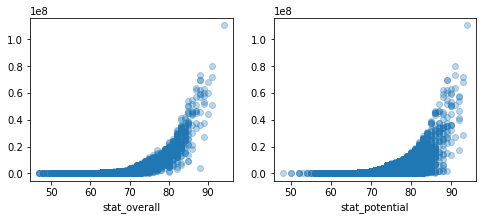

In [ ]:
plot_data = fifa_train[['value','stat_overall','stat_potential']].copy() 
fig = plt.figure(figsize=(8,3)) 
for count,col in enumerate(['stat_overall','stat_potential']):
    ax = fig.add_subplot(1,2,count+1) 
    x = plot_data[col]
    y = plot_data['value']
    ax.scatter(x,y,alpha=0.3)
    ax.set_xlabel(col)

Of course, I could see that the higher the competence, the higher the value. And practically exercising one's competence rather than potential competencies seems to be more effective in raising value.

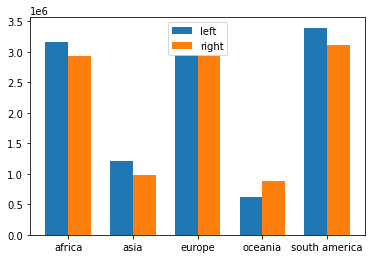

In [ ]:
plot_data = fifa_train.groupby(['continent','prefer_foot']).agg({'value':np.mean}).pivot_table(index='continent',columns='prefer_foot')['value']
fig = plt.figure() 
ax = fig.add_subplot() 
x = np.arange(len(plot_data.index))
x_lbl = plot_data.index
y1 = plot_data['left']
y2 = plot_data['right']
width = 0.35
ax.bar(x-width/2,y1,width=width,label='left')
ax.bar(x+width/2,y2,width=width,label='right')
ax.set_xticks(x)
ax.set_xticklabels(x_lbl)
ax.legend()

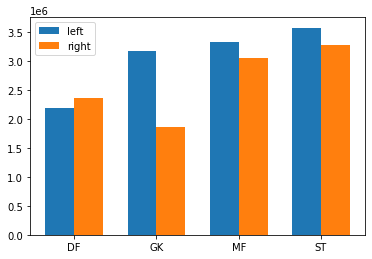

In [ ]:
plot_data = fifa_train.groupby(['position','prefer_foot']).agg({'value':np.mean}).pivot_table(index='position',columns='prefer_foot')['value']
fig = plt.figure() 
ax = fig.add_subplot() 
x = np.arange(len(plot_data.index))
x_lbl = plot_data.index
y1 = plot_data['left']
y2 = plot_data['right']
width = 0.35 
ax.bar(x-width/2,y1,width=width,label='left')
ax.bar(x+width/2,y2,width=width,label='right')
ax.legend() 
ax.set_xticks(x)
ax.set_xticklabels(x_lbl)
plt.show()

In addition, I drew a bar graph using continental information and the average  value of the preferred foot. Although Asian and Oceanian players' value is lower than continental players, their value does not seem to vary much depending on their preferred feet. By position, the player using the right foot has different values depending on the position, and the player using the left foot has a higher average salary in the order of defender, goalkeeper, midfielder, and striker. On the contrary, the goalkeeper had some differences in average value depending on his preferred foot.
 


In any case, in this process, We could see that the value changes depending on how we combine the continents, positions, and prefered foot. Almost all variables are meaningful.



I then proceeded with **data scaling** to apply these variables to machine learning algorithms.

In [ ]:
from pandas import Series, DataFrame


fifa_train['prefer_foot'] = fifa_train['prefer_foot'].map({'left':1,'right':0})
fifa_train['continent'] = fifa_train['continent'].map({'south america':1,'europe':2,'africa':3,'asia':4,'oceania':5})
fifa_train['position'] = fifa_train['position'].map({'ST':1,'GK':2,'DF':3,'MF':4})
fifa_train['contract_until'] = fifa_train['contract_until'].apply(lambda x : x-2018)


In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler = MinMaxScaler() 
scaler.fit(fifa_train[['age']])
age_scaled = scaler.transform(fifa_train[['age']])

scaler = MinMaxScaler() 
scaler.fit(fifa_train[['stat_overall','stat_potential']])
stat_scaled = scaler.transform(fifa_train[['stat_overall','stat_potential']])


In [ ]:
fifa_train

id                name  ...  stat_skill_moves      value
0         0            L. Messi  ...                 4  110500000
1         3              De Gea  ...                 1   72000000
2         7           L. Suárez  ...                 3   80000000
3         8        Sergio Ramos  ...                 3   51000000
4         9            J. Oblak  ...                 1   68000000
...     ...                 ...  ...               ...        ...
8927  16925          S. Adewusi  ...                 3      60000
8928  16936           C. Ehlich  ...                 2      40000
8929  16941          N. Fuentes  ...                 2      50000
8930  16942            J. Milli  ...                 1      50000
8931  16948  N. Christoffersson  ...                 2      60000

[8932 rows x 12 columns]

In [ ]:
X = fifa_train.drop(columns=['id','name','value'])
y = fifa_train['value']

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor() 
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Next, let's check the **test data**.

In [ ]:
fifa_test

id               name  ...  stat_potential stat_skill_moves
0         1  Cristiano Ronaldo  ...              94                5
1         2          Neymar Jr  ...              93                5
2         4       K. De Bruyne  ...              92                4
3         5          E. Hazard  ...              91                4
4         6          L. Modrić  ...              91                4
...     ...                ...  ...             ...              ...
3823  16924           R. Takae  ...              63                2
3824  16929       L. Wahlstedt  ...              65                1
3825  16932            Y. Góez  ...              65                2
3826  16937         A. Kaltner  ...              61                2
3827  16943        K. Fujikawa  ...              61                2

[3828 rows x 11 columns]

In the same way as train data, I proceed **data scaling** with test data.

In [ ]:
fifa_test['prefer_foot'] = fifa_test['prefer_foot'].map({'left':1,'right':0})
fifa_test['continent'] = fifa_test['continent'].map({'south america':1,'europe':2,'africa':3,'asia':4,'oceania':5})
fifa_test['position'] = fifa_test['position'].map({'ST':1,'GK':2,'DF':3,'MF':4})
fifa_test['contract_until'] = fifa_test['contract_until'].apply(lambda x : x-2018)


In [ ]:
scaler = MinMaxScaler() 
scaler.fit(fifa_test[['age']])
age_scaled = scaler.transform(fifa_test[['age']])

scaler = MinMaxScaler() 
scaler.fit(fifa_test[['stat_overall','stat_potential']])
stat_scaled = scaler.transform(fifa_test[['stat_overall','stat_potential']])

In [ ]:
fifa_test

id               name  ...  stat_potential  stat_skill_moves
0         1  Cristiano Ronaldo  ...              94                 5
1         2          Neymar Jr  ...              93                 5
2         4       K. De Bruyne  ...              92                 4
3         5          E. Hazard  ...              91                 4
4         6          L. Modrić  ...              91                 4
...     ...                ...  ...             ...               ...
3823  16924           R. Takae  ...              63                 2
3824  16929       L. Wahlstedt  ...              65                 1
3825  16932            Y. Góez  ...              65                 2
3826  16937         A. Kaltner  ...              61                 2
3827  16943        K. Fujikawa  ...              61                 2

[3828 rows x 11 columns]

In [ ]:
x = fifa_test.drop(columns=['id','name'])
y_hat = rf.predict(x)

fifa_test['value'] = y_hat

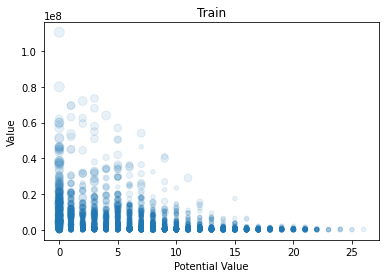

In [ ]:
fig = plt.figure() 
ax = fig.add_subplot() 
# for x1,y1 in zip(x,y):
ax.scatter(x,y,color='tab:blue',alpha=0.1,sizes=size)
ax.set_title('Train')
ax.set_xlabel('Potential Value')
ax.set_ylabel('Value')
plt.show()

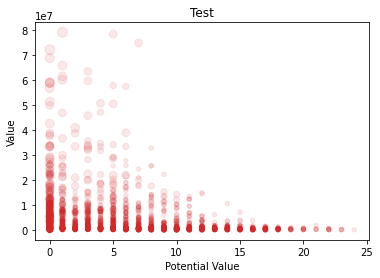

In [ ]:
 x_test = fifa_test['stat_potential']-fifa_test['stat_overall']
y_hat = fifa_test['value']

size = fifa_test['reputation']*20

fig = plt.figure() 
ax = fig.add_subplot() 
# for x1,y1 in zip(x,y):
ax.scatter(x_test,y_hat,color='tab:red',alpha=0.1,sizes=size)
ax.set_title('Test')
ax.set_xlabel('Potential Value')
ax.set_ylabel('Value')
plt.show()

The above graph was drawn with the first train set, and the below graph was drawn with the predicted values. It looks a bit similar. If you draw graphs for each continent, preferred identification, and position and compare them, the graph is similarly drawn.

The submission data file is now loaded to contain **the estimated transfer fee** information.


In [ ]:
submission = pd.read_csv(io.StringIO(uploaded['submission2.csv'].decode('utf-8')))
submission['value'] = y_hat

In [ ]:
submission

id       value
0         1  72280000.0
1         2  79300000.0
2         4  65995000.0
3         5  68955000.0
4         6  58870000.0
...     ...         ...
3823  16924     59000.0
3824  16929     50800.0
3825  16932     60100.0
3826  16937     42500.0
3827  16943     49400.0

[3828 rows x 2 columns]